# Классификация текстов

### 20.03.2017

#### Мельник Богдан
#### [teh.ld86@gmail.com](mailto:teh.ld86@gmail.com)

## Задачи классификации для текстов

* Анализ тональности текста

| Положительный | Отрицательный |
|:---:|:---:|
| <img src='files/images/kinopoisk_good.png' width='400'/> | <img src='files/images/kinopoisk_bad.png' width='400'/> |


## Задачи классификации для текстов

* Анализ тональности текста
* Фильтрация спама

<img src='files/images/spam.jpg' width='400'/>

## Задачи классификации для текстов

* Анализ тональности текста
* Фильтрация спама
* Определение языка документа

<img src='files/images/languages.jpg' width='400'/>

## Задачи классификации для текстов

* Анализ тональности текста
* Фильтрация спама
* Определение языка документа
* Проставление тегов документам 

<img src='files/images/so.png' width='400'/>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

In [40]:
import pandas as pd

from IPython.display import Image, display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

## Работа с разреженными данными

Существует много типов разреженных матриц, каждый из которых предоставляет разные гарантии на операции.

* ```scipy.sparse.bsr_matrix```
* ```scipy.sparse.coo_matrix```
* ```scipy.sparse.csc_matrix```
* ```scipy.sparse.csr_matrix```
* ```scipy.sparse.dia_matrix```
* ```scipy.sparse.dok_matrix```
* ```scipy.sparse.lil_matrix```

Подробнее про [разреженые матрицы](https://docs.scipy.org/doc/scipy/reference/sparse.html)

## Конкатенация

Для разреженных матриц есть свои ```hstack``` и ```vstack```, которые находятся в ```scipy.sparse```

### Что можно использовать?

Подходят почти все модели
* LogisticRegression
* LinearSVC
* MultinomialNB
* RandomForestClassifier
* KNeighborsClassifier

Не подходят
* GradientBoostingClassifier

## Пример задачи

* 10 тысяч вопросов со StackOverflow
* Каждый вопрос имеет либо тег __windows__, либо тег __linux__.

Мы хотим  по тексту вопроса определить его тег.

In [293]:
texts = pd.read_csv('windows_vs_linux.10k.tsv', header=None, sep='\t')
texts.columns = ['text', 'is_windows']
print(texts.shape)
texts.head(4)

(10000, 2)


,text,is_windows
0,so i find myself porting a game that was orig...,0
1,i ve been using tortoisesvn in a windows envi...,1
2,we are using wmv videos on an internal site a...,1
3,on one linux server running apache and php 5 ...,0


## Bag of words

В качестве признаков будем использовать факт вхождения слова в документ.

In [9]:
vectorizer = CountVectorizer(binary=True)
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 40971)
<class 'scipy.sparse.csr.csr_matrix'>


## Выбор модели и оценка

* Будем использовать LogisticRegression
* "C" подберём с помощью GridSearchCV

In [16]:
params = {'C': np.logspace(-5, 5, 11)}

clf = LogisticRegression()
cv = GridSearchCV(clf, params, n_jobs=-1, scoring='roc_auc', cv=5)
cv.fit(bow, texts.is_windows);

## Выбор модели и оценка

* $AUC = 0.965813$
* Довольно простая задача для случая из двух тегов

In [18]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
4,0.965813,{u'C': 0.1}
5,0.962415,{u'C': 1.0}
3,0.961759,{u'C': 0.01}
6,0.955353,{u'C': 10.0}
7,0.948635,{u'C': 100.0}
2,0.945693,{u'C': 0.001}
8,0.945429,{u'C': 1000.0}
9,0.943599,{u'C': 10000.0}
10,0.942903,{u'C': 100000.0}
1,0.790566,{u'C': 0.0001}


## Получение слов с наибольшим весом


In [49]:
def get_top_windows(clf, n):
    indices = np.zeros(bow.shape[1])
    for i in np.argsort(clf.coef_)[:, -n:]:
        indices[i] = 1
    
    return vectorizer.inverse_transform(indices)[0][::-1]

def get_top_linux(clf, n):
    indices = np.zeros(bow.shape[1])
    for i in np.argsort(clf.coef_)[:, :n]:
        indices[i] = 1
    
    return vectorizer.inverse_transform(indices)[0][::-1]

In [60]:
top = pd.DataFrame([get_top_windows(cv.best_estimator_, 6),
                    get_top_linux(cv.best_estimator_, 6)]).T

top.columns = ['Windows', 'Linux']
top

,Windows,Linux
0,windows,ubuntu
1,win32,root
2,vista,mono
3,exe,linux
4,dll,kernel
5,batch,bash


## Отбор признаков

Представим, что у нас есть очень много признаков и мы хотим сократить их количество, выбрав только самые нужные.

В данном случае мы взяли все возможные $N$-граммы, где $N \in \{1, \dots, 4\}$

In [310]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 4))
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 2117115)
<class 'scipy.sparse.csr.csr_matrix'>


## Выбираем признаки

Мы можем отобрать $50000$ признаков с помощью ```SelectKBest``` и увидеть, что мы получили на кросс-валидации качество  лучше чем до этого.

Есть ли тут проблемы?

In [311]:
k_best = SelectKBest(k=50000)
bow_k_best = k_best.fit_transform(bow, texts.is_windows)

In [312]:
clf = LogisticRegression()
np.mean(cross_val_score(clf, bow_k_best, texts.is_windows, scoring='roc_auc', cv=5))

0.97955838190531419

## Проверка

Когда делается отбор признаков всегда нужна проверка на отложенной выборке, иначе оценка будет сильно завышена.

In [313]:
x_train, x_test, y_train, y_test = train_test_split(bow, texts.is_windows)
print(x_train.shape)
print(x_test.shape)

(7500, 2117115)
(2500, 2117115)


In [314]:
k_best = SelectKBest(k=50000)
x_train_k_best = k_best.fit_transform(x_train, y_train)
x_test_k_best = k_best.transform(x_test)

In [315]:
clf = LogisticRegression()
clf.fit(x_train_k_best, y_train)
roc_auc_score(y_test, clf.predict_proba(x_test_k_best)[:, 1])

0.96876106147585705

## AUC

* Метрика для бинарной классификации
* Важен порядок ответов, а не сами значения

In [66]:
y_hat = cross_val_predict(cv.best_estimator_, bow, texts.is_windows, method='predict_proba')[:, 1]
y_hat[:5]

array([ 0.12431717,  0.99933152,  0.98910196,  0.02073042,  0.84102736])

Делая любое преобразование, сохраняющее порядок, мы будет получать одинаковое значение $AUC$

In [71]:
print(roc_auc_score(texts.is_windows, y_hat))
print(roc_auc_score(texts.is_windows, y_hat * 2 + 1)) 
print(roc_auc_score(texts.is_windows, y_hat ** 2)) 

0.963904819501
0.963904819501
0.963904819501


## AUC — Area under curve

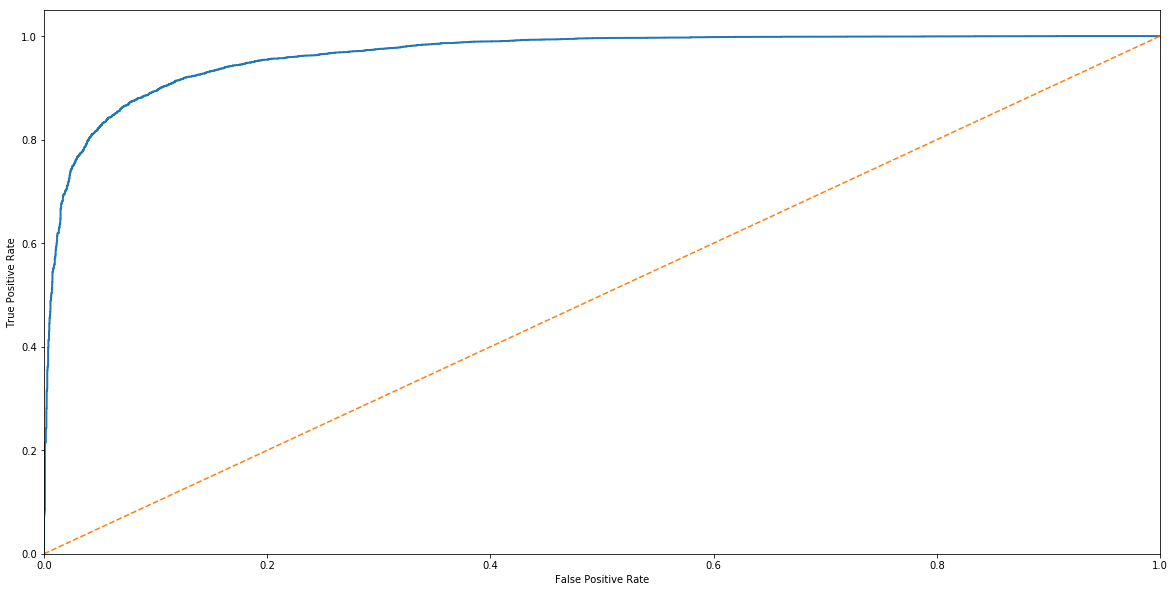

In [80]:
fpr, tpr, _ = roc_curve(texts.is_windows, y_hat)
plot(fpr, tpr, lw=2);
plot([0, 1], [0, 1], linestyle='--');
xlim([0.0, 1.0])
ylim([0.0, 1.05])
xlabel('False Positive Rate')
ylabel('True Positive Rate');

## Многоклассовая классификация

* Каждый вопрос имеет несколько тегов
* По тексту нужно определить все теги для каждого вопроса

In [31]:
texts = pd.read_csv('multi_tag.10k.tsv', header=None, sep='\t')
texts.columns = ['text', 'tags']
print(texts.shape)
texts.head(4)

(10000, 2)


,text,tags
0,i want to use a track bar to change a form s ...,c# winforms type-conversion decimal opacity
1,i have an absolutely positioned div containin...,html css css3 internet-explorer-7
2,given a datetime representing a person s birt...,c# .net datetime
3,given a specific datetime value how do i disp...,c# datetime datediff relative-time-span


## Обощение бинарной классификации

Некоторые методы умеют работать с несколькими метками из коробки

* ```KNeighborsClassifier```
* ```RandomForestClassifier```
* ```SVC```

Остальные можно обобщить с помощью обучения нескольких моделей

* ```OneVsRestClassifier```
* ```OneVsOneClassifier```

## OneVsRestClassifier

Обучает $K$ моделей, для каждой метки отдельно 

![ovr](files/images/ovr.png)

## OneVsOneClassifier

Обучает $\frac{K (K - 1)}{2}$ моделей, для каждой пары меток

![ovr](files/images/ovo.png)

## Оценка качества

* Для нескольких классов $AUC$ не подходит
* Будем использовать обобщение $F$—меры на несколько классов


$$
F1 = 2\frac{p * r}{p + r},\ \ \mathrm{где}\ \ p = \frac{tp}{tp+fp},\ \  r = \frac{tp}{tp+fn}
$$


$tp$, $fp$ и $fp$ будут считаться по всем тегам одного объекта

In [109]:
y, y_hat = np.array([[1, 1, 0, 0]]), np.array([[1, 0, 1, 0]])
tp, fp, fn = 1., 1., 1.
p, r = tp / (tp + fp), tp / (tp + fn)
f1 = 2 * p * r / (p + r)

print(f1)
print(f1_score(y, y_hat, average='samples'))

0.5
0.5


## Bag of words

Повторим всё, как для случая двух классов

In [111]:
vectorizer = CountVectorizer(binary=True)
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 35247)
<class 'scipy.sparse.csr.csr_matrix'>


## Отбор тегов

* Оставим только самые популярные 20 тегов для предсказания
* Если у вопроса после такой фильтрации не осталось тегов, то присвоим ему отдельный тег __other__

In [32]:
tags = texts.tags.apply(lambda x: x.split())
all_tags = reduce(lambda s, x: s + x, tags, [])
values, count = np.unique(all_tags, return_counts=True)

top_tags = sorted(zip(count, values), reverse=True)[:20]
top_tags[:5]

[(1198, 'c#'),
 (1090, '.net'),
 (696, 'java'),
 (610, 'asp.net'),
 (472, 'sql-server')]

In [33]:
def filter_tags(tags):
    intersection = list(good_tags.intersection(tags))
    if intersection:
        return intersection
    return ['other']

good_tags = set(map(lambda x: x[1], top_tags))

Преобразуем списки тегов в матрицу, которая будет содержать индикаторы наличия тега у вопроса.

In [34]:
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(texts.tags.apply(lambda x: filter_tags(x.split())))
print(y.shape)
print(type(y))

(10000, 21)
<type 'numpy.ndarray'>


## Выбор модели и оценка

* Также будет использовать ```LogisticRegression```, но уже вместе с ```OneVsRestClassifier```

In [204]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(bow, y);

## Выбор модели и оценка

* $F1 = 0.4047323$
* Как видно задача стала существенно сложней
* Попробуем улучшить качество

In [205]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.404732,{u'estimator__C': 100000.0}
9,0.404212,{u'estimator__C': 10000.0}
8,0.404140,{u'estimator__C': 1000.0}
7,0.403066,{u'estimator__C': 100.0}
6,0.402630,{u'estimator__C': 10.0}
5,0.390346,{u'estimator__C': 1.0}
4,0.319707,{u'estimator__C': 0.1}
3,0.092920,{u'estimator__C': 0.01}
2,0.000300,{u'estimator__C': 0.001}
0,0.000000,{u'estimator__C': 1e-05}


## Tf-Idf

* Вместо бинарного значения, для каждого слова считается его вес
* Обычно работает лучше, чем ```CountVectorizer```

In [253]:
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(texts.text)
print(tf_idf.shape)
print(type(tf_idf))

(10000, 35247)
<class 'scipy.sparse.csr.csr_matrix'>


## Выбор модели и оценка

Ищем лучшие параметры

In [254]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(tf_idf, y);

## Выбор модели и оценка

* $F1=0.382173$
* Получилось хуже, чем BOW.
* Но почему?

In [255]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.382173,{u'estimator__C': 100000.0}
9,0.380033,{u'estimator__C': 10000.0}
8,0.376427,{u'estimator__C': 1000.0}
7,0.364680,{u'estimator__C': 100.0}
6,0.334247,{u'estimator__C': 10.0}
5,0.182323,{u'estimator__C': 1.0}
4,0.000700,{u'estimator__C': 0.1}
0,0.000000,{u'estimator__C': 1e-05}
1,0.000000,{u'estimator__C': 0.0001}
2,0.000000,{u'estimator__C': 0.001}


## Выбор порога

* При вызове ```predict``` возвращается 1, если вероятность принадлежности к классу больше $0.5$
* Можно выбирать порог самому через кросс-валидацию

In [260]:
clf = OneVsRestClassifier(LogisticRegression(C=100000))
y_hat_bow = cross_val_predict(clf, bow, y, method='predict_proba')
y_hat_tf_idf = cross_val_predict(clf, tf_idf, y, method='predict_proba')

Функция, которая в зависимости от порога ставит тег

In [30]:
def get_score(alpha, y, y_hat):
    return f1_score(y, (y_hat > alpha).astype('int'), average='samples')

## Выбор порога для BOW

* Качество с порогом по умолчанию — $F1=0.404732$
* Качество с подобранным порогом — $F1=0.454356$

0.454356904762
0.00535353535354


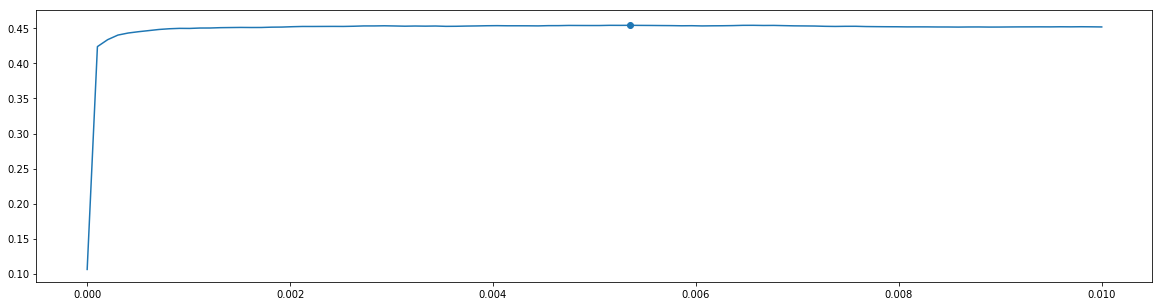

In [270]:
alphas = np.linspace(0.0, 0.01, 100)
scores = [get_score(alpha, y, y_hat_bow) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
print(np.max(scores))
print(alphas[np.argmax(scores)])

## Выбор порога для Tf-Idf

* Качество с порогом по умолчанию — $F1=0.382173$
* Качество с подобранным порогом — $F1=0.493972$

0.493972857143
0.00191919191919


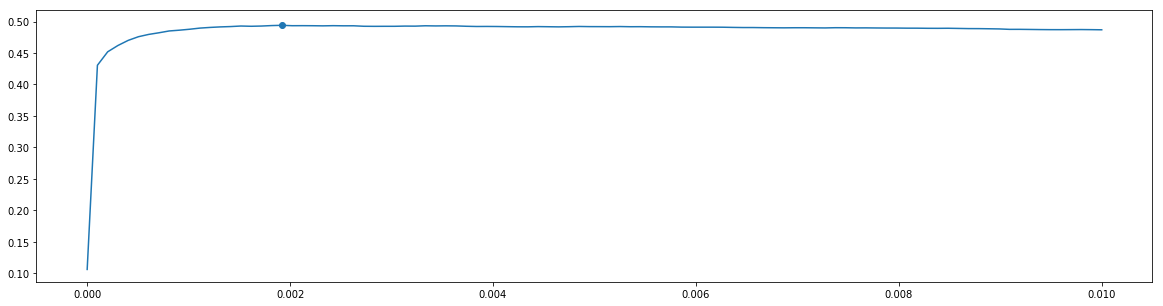

In [271]:
alphas = np.linspace(0.0, 0.01, 100)
scores = [get_score(alpha, y, y_hat_tf_idf) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
print(np.max(scores))
print(alphas[np.argmax(scores)])

## N-граммы

* При увеличении N количество признаков стремительно растёт
* Даже для 10 тысяч объектов валидация и подбор гиперпараметров существенно замедляются

In [273]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 1132373)
<class 'scipy.sparse.csr.csr_matrix'>


## Hashing Trick

Вместо того, чтобы хранить каждый вариант N-граммы отдельно, мы будем получать индекс столбца, хешируя содержимое.

Позволяет задавать произвольное количество столбцов.

In [278]:
vectorizer = HashingVectorizer(binary=True, ngram_range=(1, 3), n_features=50000)
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 50000)
<class 'scipy.sparse.csr.csr_matrix'>


In [280]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(bow, y);

In [281]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.280800,{u'estimator__C': 100000.0}
9,0.275890,{u'estimator__C': 10000.0}
8,0.265307,{u'estimator__C': 1000.0}
7,0.247607,{u'estimator__C': 100.0}
6,0.200850,{u'estimator__C': 10.0}
5,0.055257,{u'estimator__C': 1.0}
0,0.000000,{u'estimator__C': 1e-05}
1,0.000000,{u'estimator__C': 0.0001}
2,0.000000,{u'estimator__C': 0.001}
3,0.000000,{u'estimator__C': 0.01}


## Выбор порога для HashingTrick

* Качество с подобранным порогом — $F1=0.509255$

In [282]:
clf = OneVsRestClassifier(LogisticRegression(C=100000))
y_hat_bow = cross_val_predict(clf, bow, y, method='predict_proba')

0.509255
0.00191919191919


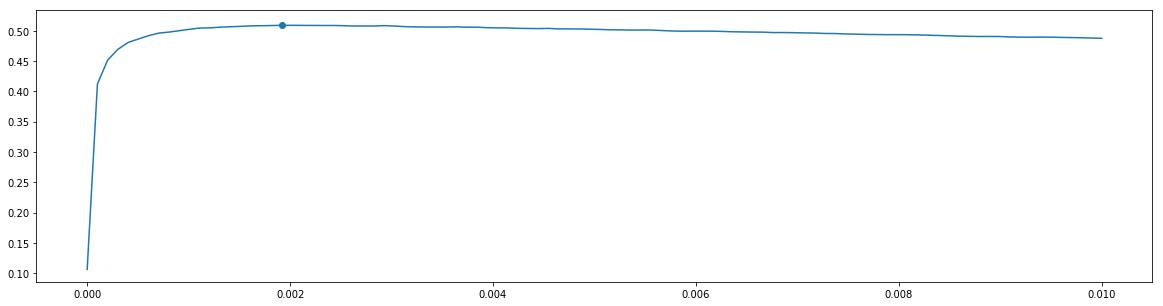

In [283]:
alphas = np.linspace(0.0, 0.01, 100)
scores = [get_score(alpha, y, y_hat_bow) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
print(np.max(scores))
print(alphas[np.argmax(scores)])

## Понижение размерности

Можно получать ```dense``` матрицы любым способом, который вам нравится.

Позволяет сократить время обучения и использовать методы, которые больше подходят ```dense``` матрицы.

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tf_idf = vectorizer.fit_transform(texts.text)
print(tf_idf.shape)
print(type(tf_idf))

(10000, 397950)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
svd = TruncatedSVD(n_components=200, n_iter=5)
tf_idf_svd = svd.fit_transform(tf_idf)

In [ ]:
clf = OneVsRestClassifier(LogisticRegression())
y_hat_tf_idf_svd = cross_val_predict(clf, tf_idf_svd, y, method='predict_proba')

In [ ]:
alphas = np.linspace(0.1, 0.3, 100)
scores = [get_score(alpha, y, y_hat_tf_idf_svd) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
print(np.max(scores))
print(alphas[np.argmax(scores)])

## Блендинг

Когда у нас есть несколько моделей, мы можем получать смешенное предсказание.

Если модели не сильно скоррелированы, то зачастую мы можем улучшить качество результирующей модели. 

In [35]:
vectorizer = HashingVectorizer(binary=True, ngram_range=(1, 3), n_features=50000)
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 50000)
<class 'scipy.sparse.csr.csr_matrix'>


In [36]:
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(texts.text)
print(tf_idf.shape)
print(type(tf_idf))

(10000, 35247)
<class 'scipy.sparse.csr.csr_matrix'>


## Предсказания

С помощью кросс-валидации предскажем обучающую выборку для каждой модели.

В итоге мы получим несмещённые предсказания для объектов, у которых уже знаем метки.

In [41]:
folds = KFold(random_state=123)

In [42]:
clf_lr = OneVsRestClassifier(LogisticRegression(C=100000))
y_hat_lr = cross_val_predict(clf_lr, bow, y, method='predict_proba', cv=folds)

In [43]:
clf_lr = OneVsRestClassifier(LogisticRegression(C=100000))
y_hat_lr_tf_idf = cross_val_predict(clf_lr, tf_idf, y, method='predict_proba', cv=folds)

## Оценка

Получим качество на каждой моделе в отдельности и на их смеси.
* Качество первой модели — $F1=0.5092$
* Качество второй модели — $F1=0.4935$
* Качество их смеси — $F1=0.5270$

In [50]:
alphas = np.linspace(0.0, 0.02, 100)
lr_scores = [get_score(alpha, y, y_hat_lr) for alpha in alphas]
nb_scores = [get_score(alpha, y, y_hat_lr_tf_idf) for alpha in alphas]
lr_nb_scores = [get_score(alpha, y, 0.5 * y_hat_lr_tf_idf + 0.5 * y_hat_lr) for alpha in alphas]

print(np.max(lr_scores))
print(np.max(nb_scores))
print(np.max(lr_nb_scores))

0.50923452381
0.493558095238
0.527097619048


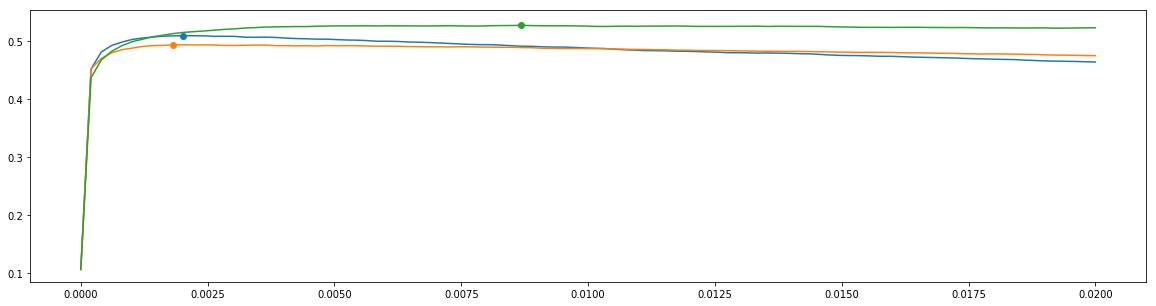

In [51]:
plot(alphas, lr_scores);
plot(alphas, nb_scores);
plot(alphas, lr_nb_scores);

scatter(alphas[np.argmax(lr_scores)], np.max(lr_scores));
scatter(alphas[np.argmax(nb_scores)], np.max(nb_scores));
scatter(alphas[np.argmax(lr_nb_scores)], np.max(lr_nb_scores));

## Стекинг

Вместо ручного смешивания результатов мы можем подавать их на вход другим алгоритмам.

Подготовим переменную  ```stacked```, которая будет содержать предсказания предыдущих алгоритмов

In [46]:
stacked = np.hstack([y_hat_lr, y_hat_lr_tf_idf])
clf_stacked = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
y_hat_stacked = cross_val_predict(clf_stacked, stacked, y, method='predict_proba', cv=folds)

## Оценка

После подбора порога получим $F1=0.547874$, что больше всех предыдущих результатов.

0.547874126984
0.232323232323


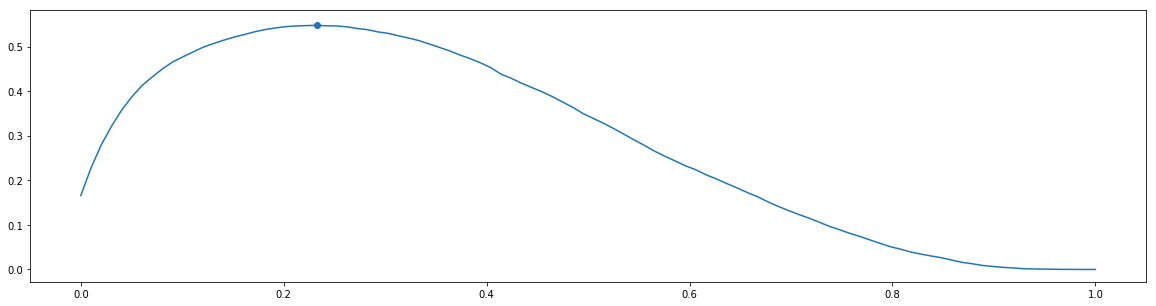

In [47]:
alphas = np.linspace(0, 1, 100)
scores = [get_score(alpha, y, y_hat_stacked) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
print(np.max(scores))
print(alphas[np.argmax(scores)])

## Больше про стекинг 

Почти во всех конкурсах так или иначе используется стекинг или блендинг, поэтому очень важно понимать как они работают и как их использовать.

* [Kaggle Ensembling Guide](http://mlwave.com/kaggle-ensembling-guide/)
* [Стекинг и блендинг (Дьяконов)](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending/#more-4558)

## VW

* Разработка Yahoo и потом Microsoft
* Библиотека и __CLI__ программа, позволяющая строить линейные модели
* Способна обрабатывать миллиарды объектов с сотнями тысяч признаков

## Установка VW

* Ubuntu — ```apt-get instal vowpal-wabbit```
* Mac OS — ```port install vowpal_wabbit```
* Windows — скачать установочник [тут](https://github.com/eisber/vowpal_wabbit/releases)

[Варианты](https://github.com/JohnLangford/vowpal_wabbit/wiki/Download) установки из официальной wiki

## Проверяем VW

In [53]:
!vw -h

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all 

## Формат ввода

* Использует необычный формат входных данных
* ```Label [weight] |Namespace Feature ... |Namespace ...```
    * ```Label``` — метка класса для задачи классификации или действительное число для задачи регрессии
    * ```weight``` — вес объекта, по умолчанию у всех одинаковый
    * ```Namespace``` — все признаки разбиты на области видимости, может использоваться для раздельного использования или создания квадратичных признаков между областями
    * ```Feature``` — ```string[:value]``` или ```int[:value]``` строки будут хешированы, числа будут использоваться как индекс в векторе признаков. ```value``` по умолчанию равно $1$

## Hashing trick

Вводится функция $h$, с помощью которой получается индекс для записи значения в вектор признаков объекта.

$$h : F \rightarrow \{0, \dots, 2^b - 1\}$$

С помощью ```--b``` можно задавать размер области значений хеш-функции.

## Optimization

Может использовать ```SGD``` или ```L-BFGS```

* ```SGD``` по умолчанию, позволяет делать онлайн обучение. Почти всегда необходимо несколько проходов по данным.
* ```L-BFGS``` включается с помощью ```--bfgs```, работает только с данными небольшого размера
* Количество проходов для ```SGD``` задаётся с помощью параметра ```--passes```

## Параметры оптимизации

Проходим по всем элементам обучающей выборки много раз, на каждом объекте делаем поправку весов:
<br/>


$$w_{t+1} = w_{t} + \eta_t \nabla_{w}\ell(w_{t}, x_{t})$$
$$\eta_t = \lambda d^k \left( \frac{t_0}{t_0 + w} \right)^p$$

Здесь $t$ — порядковый номер объекта обучения, $k$ — номер прохода по всей выборке.

* $\lambda$:  ``-l`` (learning rate) <br/>
* $d$: ``--decay_learning_rate`` <br/>
* $t_0$: ``--initial_t`` <br/>
* $p$: ``--power_t`` <br/>
* $k_{max}$: ``--passes``

## Оценка качества

``average loss`` — loss by [progressive validation](http://hunch.net/~jl/projects/prediction_bounds/progressive_validation/coltfinal.pdf)



$$\text{Progressive error} = \frac{e_1 + e_2 + ... + e_s}{s}$$




$e_i$ — loss на объекте $x_i$ при обучении на объектах $\{x_1 ... x_{i-1}\}$

## Примеры для бинарной классификации

* Два класса с признаками A и B

<pre>
-1 | A:1 B:10
 1 | A:-1 B:12
</pre>

* Можно использовать текст без обработки

<pre>
-1 | so i find myself porting a game that was originally written
 1 | i ve been using tortoisesvn in a windows environment for quite some time
</pre>

## Попробуем решить ```windows vs linux```

Для этого сначала сконвертируем данные в формат для ```vw```

In [171]:
texts = pd.read_csv('windows_vs_linux.10k.tsv', sep='\t', header=None)
texts[1].replace({0: '-1 ', 1: '1 '}, inplace=True)

train_texts, test_texts = train_test_split(texts)


train_texts[[1, 0]].to_csv('win_vs_lin.train.vw', sep='|', header=None, index=False)
test_texts[[1, 0]].to_csv('win_vs_lin.test.vw', sep='|', header=None, index=False)

!head -n 5 win_vs_lin.train.vw | cut -c 1-50

1 | i have a bat file shown below echo off for f d
1 | i need a way to determine whether the computer
-1 | my c application uses 3rd libraries which do 
-1 | currently i m trying to install php 5 3 0 on 
1 | i how to get the windowproc for a form in c fo


## Обучение

In [172]:
!vw -d win_vs_lin.train.vw --loss_function logistic -P 10000 -f model.vw --passes 100 -c

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = win_vs_lin.train.vw.cache
Reading datafile = win_vs_lin.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.342860 0.342860        10000        10000.0   1.0000   3.3821       95 h
0.301154 0.259449        20000        20000.0   1.0000   4.0657       69 h
0.289920 0.267450        30000        30000.0  -1.0000  -4.0597      170 h
0.280396 0.251826        40000        40000.0  -1.0000  -2.4205      101 h
0.276837 0.262603        50000        50000.0  -1.0000  -7.5515      245 h
0.272949 0.253507        60000        60000.0  -1.0000  -5.6810      138 h

finished run
number of examples per pass = 6750
passes used = 10
weighted example sum = 67500.000000
weighted label sum = 14760.000000
average loss = 0.256594 h
best constant = 0.4

## Применение

In [173]:
!vw -i model.vw -t -p output.csv win_vs_lin.test.vw --loss_function logistic

only testing
predictions = output.csv
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = win_vs_lin.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693859 0.693859            1            1.0  -1.0000   0.0014       46
0.794020 0.894181            2            2.0  -1.0000   0.3683      252
0.852172 0.910324            4            4.0  -1.0000   1.2895      301
0.437393 0.022613            8            8.0   1.0000   3.0448       56
0.280665 0.123937           16           16.0   1.0000   0.7930       51
0.225321 0.169977           32           32.0   1.0000   2.8181       74
0.175063 0.124804           64           64.0   1.0000   7.9573       50
0.182200 0.189338          128          128.0   1.0000  21.6971      223
0.230316 0.278431          256          256.0  -1.0000  -1.0294      169
0.217809 0.205302    

## Результат

In [174]:
y_hat = pd.read_csv('output.csv', header=None)
roc_auc_score(test_texts[1].replace({'-1 ': 0, '1 ': 1}), y_hat[0])

0.96415249302305139

## Функции потерь

Задаются через опцию ```--loss_function```

<img src="files/images/loss.png" width="800">

## Регуляризация 

Задаётся через два флага
* ```--l1```
* ```--l2```

## Многоклассовая классификация

Включается с помощью флага ```--multilabel_oaa n```, где $n$ число классов

In [12]:
texts = pd.read_csv('multi_tag.10k.tsv', header=None, sep='\t')
texts.columns = ['text', 'tags']
classes = np.arange(21)
texts['tags'] = map(lambda row: ','.join(map(str, classes[row.astype('bool')])) + ' ', y)
texts[['tags', 'text']].to_csv('multi_tag.vw' , sep='|', header=None, index=False)

!head -n 5 multi_tag.vw | cut -c 1-80

3 | i want to use a track bar to change a form s opacity this is my code decimal
6 | i have an absolutely positioned div containing several children one of which
0,3 | given a datetime representing a person s birthday how do i calculate their
3 | given a specific datetime value how do i display relative time like 2 hours 
6,8 | is there any standard way for a web server to be able to determine a user 


## Обучение

In [13]:
!vw -d multi_tag.vw --loss_function logistic -f model.vw --multilabel_oaa 21 --passes 10 -c

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
using cache_file = multi_tag.vw.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        3                66
1.000000 1.000000            2            2.0        6        3       99
0.750000 0.500000            4            4.0        3                22
0.750000 0.750000            8            8.0        5        3        9
0.687500 0.625000           16           16.0        3                56
0.625000 0.562500           32           32.0       12               146
0.671875 0.718750           64           64.0       14               333
0.679688 0.687500          128          128.0       11       13       44
0.742188 0.804688          256          256.0       

## Предсказание

Для простоты получим ответы на ```train```

In [25]:
!vw -i model.vw -p output.csv multi_tag.vw --loss_function logistic

predictions = output.csv
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = multi_tag.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        3        3       66
0.000000 0.000000            2            2.0        6        6       99
0.750000 1.500000            4            4.0        3                22
0.750000 0.750000            8            8.0        5                 9
1.000000 1.250000           16           16.0        6        6      157
1.000000 1.000000           32           32.0       16  3 15 16      225
0.953125 0.906250           64           64.0       11       11      181
0.890625 0.828125          128          128.0        9        9       98
0.800781 0.710938          256          256.0       11       11       38
0.755859 0.710938          512          

## Конкурсы по анализу данных

* Организаторы конкурсов выдают данные
    * Обучающую выборку с ответами
    * Тестовую выборку без ответов
* Каждый участник создаёт модель локально
* Нет никаких ограничений на модель
* Сравниваются только результаты на тестовой выборке

## Kaggle-in-class

* Платформа для учебных соревнований
* До окончания соревнования виден только публичный скорборд, который считается по меньшей части тестовой выборки
* После окончания соревнования в приватный скорборд берутся только несколько попыток из участвующих в публичном 

## Конкурс

* Вам дана информация о документах и их тегах
* Всего 30000 документов и 98 тегов
* Для каждой пары документ-терм известен её вес
* Метрика такая же как в примере со stackoverflow — __Mean F1__

## Безлайны

* Мы выдаём безлайн, с помощью которого можно воспроизвести базовое решение
* Также есть более сложный безлайн — medium baseline, код от которого не выдаётся

## Оценивание 

* +5 баллов — за получение решения, которое лучше чем medium baseline до наступления промежуточного дедлайна
* +30 баллов — за первое место
* +25 баллов — за второе место
* +20 баллов — за третье место

## Правила игры

* 5 попыток в день
* Решать задания необходимо в одиночку
* Можно выбрать только две попытки в конце конкурса
* Дедлайн по конкурсу — 17 апреля в 9:00
* Промежуточный дедлайн — 3 апреля в 9:00
* Запрещается использование внешних наборов данных, не предоставленных на соревновании